In [1]:
import math
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels as sms
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

### 1) Formulate Question

Does a movie's production budget predict how well it will sell in the box office? 

What movies have big budgets but are total flops? What about movies with small budgets that turn out to be commercial blockbusters? 

### 2) Gather Data

In [2]:
cwd = os.getcwd()

df = pd.read_csv("cost_revenue_dirty.csv")
print(df.shape)
df.head()

(5391, 6)


,Rank,Release Date,Movie Title,Production Budget ($),Worldwide Gross ($),Domestic Gross ($)
0,5293,8/2/1915,The Birth of a Nation,"$110,000","$11,000,000","$10,000,000"
1,5140,5/9/1916,Intolerance,"$385,907",$0,$0
2,5230,12/24/1916,"20,000 Leagues Under the Sea","$200,000","$8,000,000","$8,000,000"
3,5299,9/17/1920,Over the Hill to the Poorhouse,"$100,000","$3,000,000","$3,000,000"
4,5222,1/1/1925,The Big Parade,"$245,000","$22,000,000","$11,000,000"


### 3) Clean/Preprocess Data

In [3]:
# 1) Renaming 

df = df.rename(columns={"Production Budget ($)": "production_budget_usd", "Worldwide Gross ($)": "worldwide_gross_usd", "Domestic Gross ($)": "domestic_gross_usd"})

# 2) Removing rows with $0

columns_to_strip = ["production_budget_usd", "worldwide_gross_usd", "domestic_gross_usd"]

for col in columns_to_strip:
    # df[col].str.replace(r"\$,.*", "", regex=True).astype(int)
    df[col] = df[col].str.strip("$").str.replace(",", "").astype("float")

# 3) Removing null data

df.isnull().sum()
df.dropna(inplace=True)

# 4) Removing duplicates

df.drop_duplicates(inplace=True)

## Descriptive Statistics

In [4]:
df.describe()

,Rank,production_budget_usd,worldwide_gross_usd,domestic_gross_usd
count,5391.000000,5.391000e+03,5.391000e+03,5.391000e+03
mean,2696.000000,3.111374e+07,8.885542e+07,4.123552e+07
std,1556.391981,4.052380e+07,1.684578e+08,6.602935e+07
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00
25%,1348.500000,5.000000e+06,3.865206e+06,1.330902e+06
50%,2696.000000,1.700000e+07,2.745045e+07,1.719220e+07
75%,4043.500000,4.000000e+07,9.645446e+07,5.234369e+07
max,5391.000000,4.250000e+08,2.783919e+09,9.366622e+08


### 4) Explore & Visulate Data

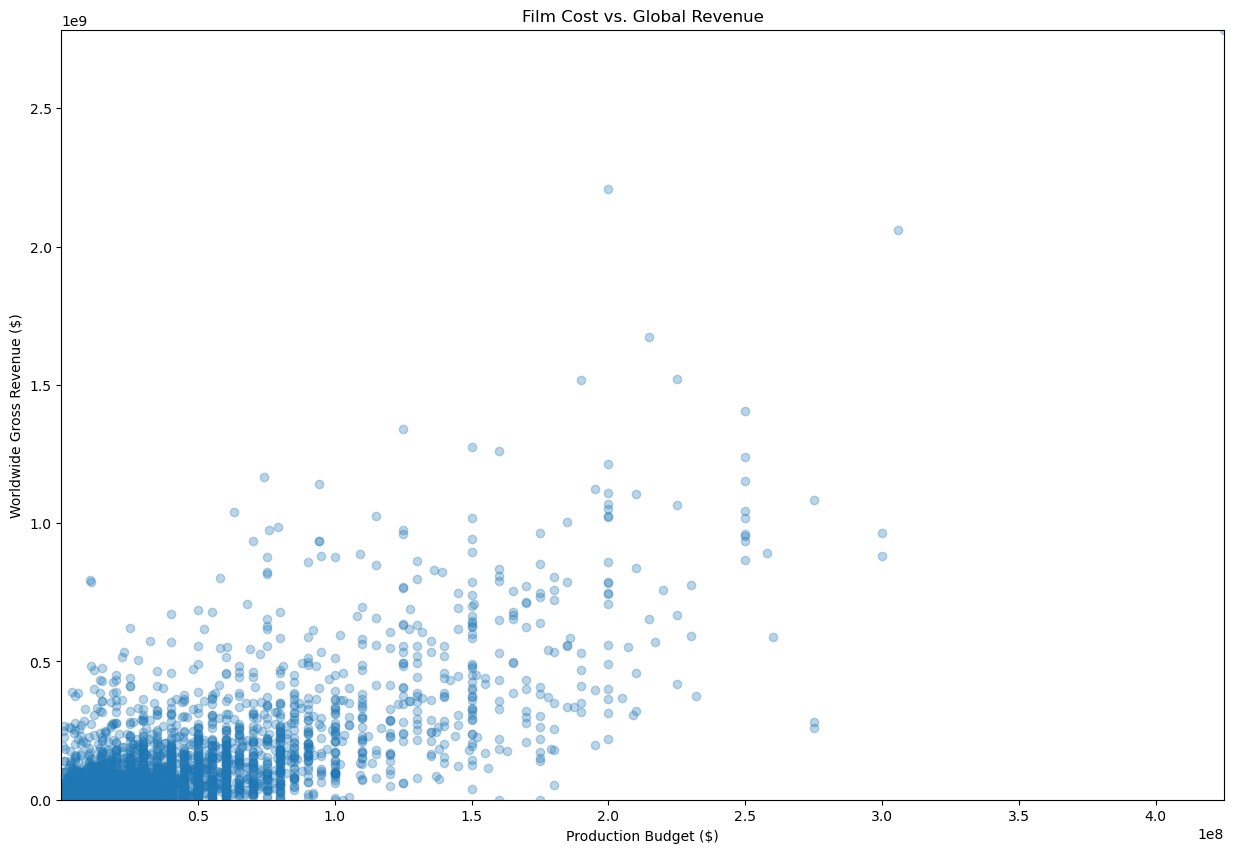

In [5]:
x = pd.DataFrame(df, columns = ["production_budget_usd"])
y = pd.DataFrame(df, columns = ["worldwide_gross_usd"])

plt.figure(figsize=(15,10))

plt.scatter(x, y, alpha=0.3)

plt.xlabel("Production Budget ($)")
plt.xlim(1.100000e+03, 4.250000e+08)

plt.ylabel("Worldwide Gross Revenue ($)")
plt.ylim(0, 2.783919e+09)

plt.title("Film Cost vs. Global Revenue")

plt.show()

### 5) Train Algorithm

In [6]:
features = df["production_budget_usd"]
target = df["worldwide_gross_usd"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10) 

In [7]:
# Ensure X_train and X_test are 2D DataFrames or arrays

if isinstance(X_train, pd.Series):
    X_train = X_train.to_frame()  # Converts Series to DataFrame
if isinstance(X_test, pd.Series):
    X_test = X_test.to_frame()

### Training Results

In [8]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_train_predict = reg.predict(X_train)
print('R-squared: ', reg.score(X_train, y_train))
print(pd.DataFrame(reg.coef_, index=X_train.columns, columns=['Coefficients']))
print('Intercept: ', reg.intercept_)

R-squared:  0.5449688116672403
                       Coefficients
production_budget_usd      3.086028
Intercept:  -7241044.583350271


In [9]:
my_list = map(lambda x: x, y_train_predict)
y_train_predict = pd.Series(my_list, name='worldwide_gross_usd')

## Inferential Statistics

### Correlation

#### $$ \rho _{XY} = Corr(XY) $$
#### $$ -1.0 \leq \rho _{XY} \leq +1.0 $$

### Regression: Actual values vs. predicted

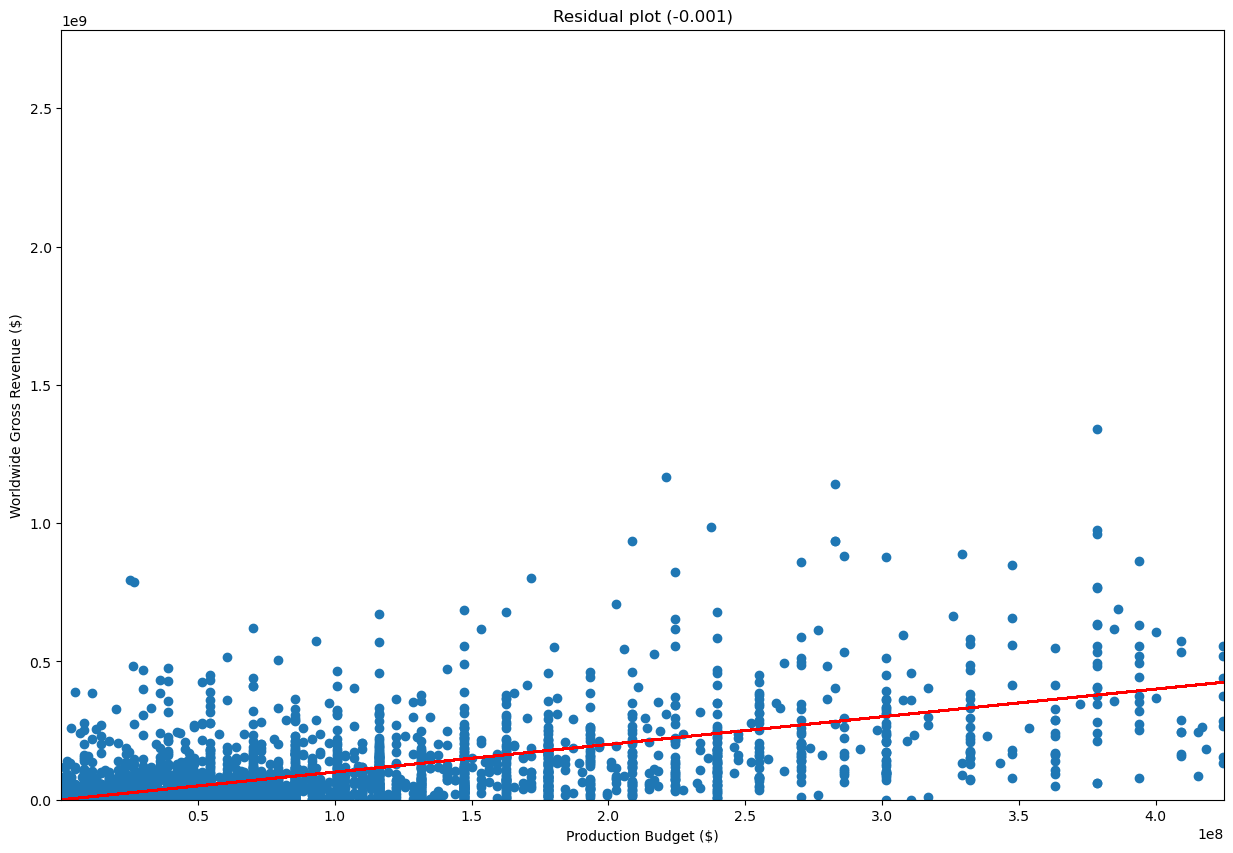

In [ ]:
correlation1 = y_train_predict.corr(y_train)

plt.figure(figsize=(15,10))
plt.scatter(y_train_predict, y_train)
plt.plot(y_train, y_train, color='red')

plt.xlabel("Production Budget ($)")
plt.ylabel("Worldwide Gross Revenue ($)")
plt.title(f'Predictions plot ({round(correlation1, 3)})')

plt.xlim(1.100000e+03, 4.250000e+08)
plt.ylim(0, 2.783919e+09)

plt.show()

### Assessing the model (e.g. coefficient p-Values)

In [11]:
X_summary1 = sm.add_constant(X_train)

model = sm.OLS(y_train, X_summary1, missing='drop')
model_result1 = model.fit()
print(model_result1.summary())

print(model_result1.resid)
print(model_result1.mse_resid)
print(mse(y_train, y_train_predict))

                             OLS Regression Results                            
Dep. Variable:     worldwide_gross_usd   R-squared:                       0.545
Model:                             OLS   Adj. R-squared:                  0.545
Method:                  Least Squares   F-statistic:                     5162.
Date:                 Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                         11:26:23   Log-Likelihood:                -86123.
No. Observations:                 4312   AIC:                         1.722e+05
Df Residuals:                     4310   BIC:                         1.723e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

### A. Checking that there's a linear relationship

### B. Showing that the residuals are independent using the Durbin-Watson statistic


In [12]:
fitted_values = model_result1.fittedvalues
residuals = model_result1.resid
durbin_watson_stat = sm.stats.durbin_watson(residuals, axis=0)

print(durbin_watson_stat)

1.9485942556941112


Because the Durbin-Watson test returns a value between 1.5 and 2.5, autocorrelation is likely not a cause for concern.

Therefore, the residuals are independent.

### C. Showing that the residuals display homoscedasticity (i.e. constant variance) using the Breusch-Pagan Test

In [13]:
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.stats.api.het_breuschpagan(residuals, model_result1.model.exog)
pd.Series(test, index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

Lagrange multiplier statistic     6.041624e+02
p-value                          2.081797e-133
f-value                           7.022800e+02
f p-value                        1.710870e-143
dtype: float64

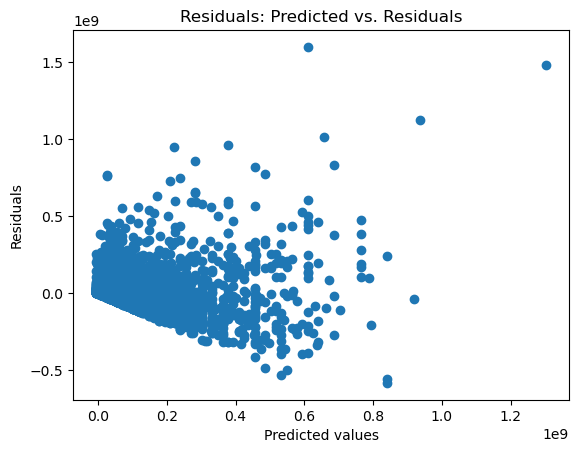

In [26]:
plt.scatter(y_train_predict, model_result1.resid)

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title(f'Residuals: Predicted vs. Residuals')

plt.show()

Since the p-value is less than our significance less (0.05), our regression is homoscedastic.

Source: https://www.statology.org/breusch-pagan-test/

### D. Showing that the residuals display normality

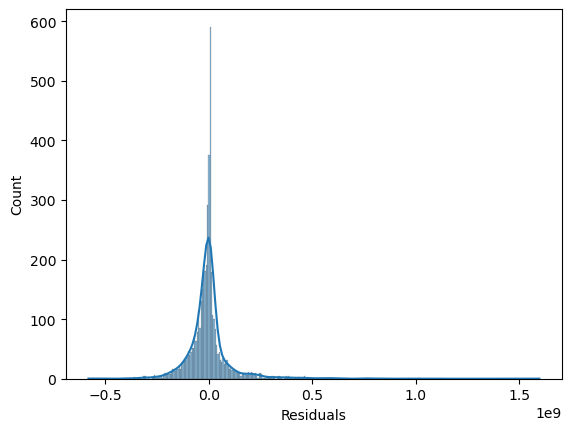

In [ ]:
# sm.qqplot(residuals, line='s')

sns.histplot(model_result1.resid, kde=True)
plt.xlabel('Residuals')
plt.show()

### Test Results

In [16]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_test_predict = reg.predict(X_test)  # Predict on test data
print('R-squared:', reg.score(X_test, y_test))
print(pd.DataFrame(reg.coef_, index=X_test.columns, columns=['Coefficients']))
print('Intercept:', reg.intercept_)

R-squared: 0.5833610432800477
                       Coefficients
production_budget_usd      3.086028
Intercept: -7241044.583350271


In [17]:
my_list = map(lambda x: x, y_test_predict)
y_test_predict = pd.Series(my_list, name='worldwide_gross_usd')

### How well does the training set fit the test set? Do new data points (i.e. test set) have similar coefficients, MSE, R-Squared, etc. as the training set?

In [18]:
# R-squared scores
r2_train = reg.score(X_train, y_train)
r2_test = reg.score(X_test, y_test)

# We need to make predictions first
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# Mean Squared Error (MSE)
mse_train = mse(y_train, y_train_predict)
mse_test = mse(y_test, y_test_predict)

# Root Mean Squared Error (RMSE)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Print metrics side by side
print(f"{'Metric':<10} {'Training':>12} {'Testing':>12}")
print('-' * 35)
print(f"{'R²':.<10} {r2_train:>12.4f} {r2_test:>12.4f}")
print(f"{'MSE':.<10} {mse_train:>12.4f} {mse_test:>12.4f}")
print(f"{'RMSE':.<10} {rmse_train:>12.4f} {rmse_test:>12.4f}")

Metric         Training      Testing
-----------------------------------
R²........       0.5450       0.5834
MSE....... 13052479697302622.0000 11297121255532190.0000
RMSE...... 114247449.4127 106287916.7899


### Regression: Actual values vs. predicted

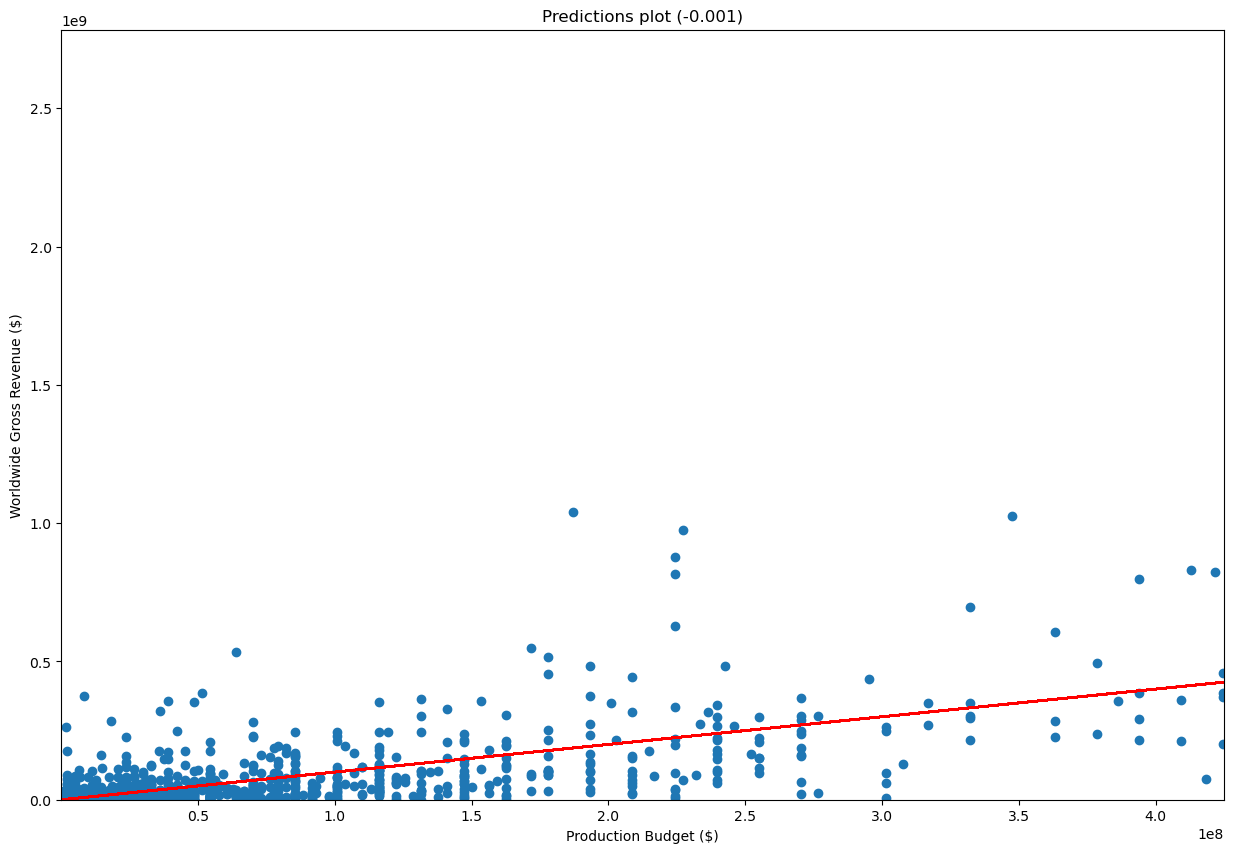

In [28]:
correlation2 = y_test_predict.corr(y_test)

plt.figure(figsize=(15,10))
plt.scatter(y_test_predict, y_test)
plt.plot(y_test, y_test, color='red')

plt.xlabel("Production Budget ($)")
plt.ylabel("Worldwide Gross Revenue ($)")
plt.title(f'Predictions plot ({round(correlation1, 3)})')

plt.xlim(1.100000e+03, 4.250000e+08)
plt.ylim(0, 2.783919e+09)

plt.show()

In [20]:
X_summary2 = sm.add_constant(X_test)

model = sm.OLS(y_test, X_summary2, missing='drop')
model_result2 = model.fit()
print(model_result2.summary())

print(model_result2.resid)
print('Mean absolute error:', model_result2.mse_resid)

                             OLS Regression Results                            
Dep. Variable:     worldwide_gross_usd   R-squared:                       0.583
Model:                             OLS   Adj. R-squared:                  0.583
Method:                  Least Squares   F-statistic:                     1508.
Date:                 Mon, 04 Nov 2024   Prob (F-statistic):          5.36e-207
Time:                         11:26:24   Log-Likelihood:                -21473.
No. Observations:                 1079   AIC:                         4.295e+04
Df Residuals:                     1077   BIC:                         4.296e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

### A. Checking that there's a linear relationship

### B. Showing that the residuals are independent using the Durbin-Watson statistic


In [21]:
fitted_values = model_result2.fittedvalues
residuals = model_result2.resid
durbin_watson_stat = sm.stats.durbin_watson(residuals, axis=0)

print(durbin_watson_stat)

2.0088030191874915


Because the Durbin-Watson test returns a value between 1.5 and 2.5, autocorrelation is likely not a cause for concern.

Therefore, the residuals are independent.

### C. Showing that the residuals display homoscedasticity (i.e. constant variance) using the Breusch-Pagan Test

In [22]:
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.stats.api.het_breuschpagan(residuals, model_result2.model.exog)
pd.Series(test, index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

Lagrange multiplier statistic    1.535868e+02
p-value                          2.851225e-35
f-value                          1.787450e+02
f p-value                        7.877628e-38
dtype: float64

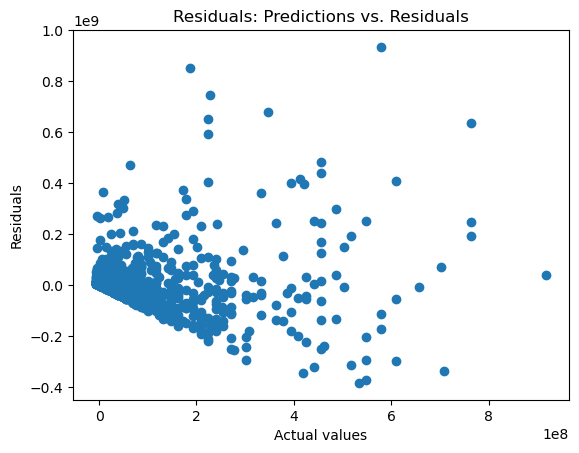

In [29]:
plt.scatter(y_test_predict, model_result2.resid)

plt.xlabel('Actual values')
plt.ylabel('Residuals')
plt.title(f'Residuals: Predictions vs. Residuals')

plt.show()

Since the p-value is less than our significance less (0.05), our regression is homoscedastic.

Source: https://www.statology.org/breusch-pagan-test/

### D. Showing that the residuals display normality

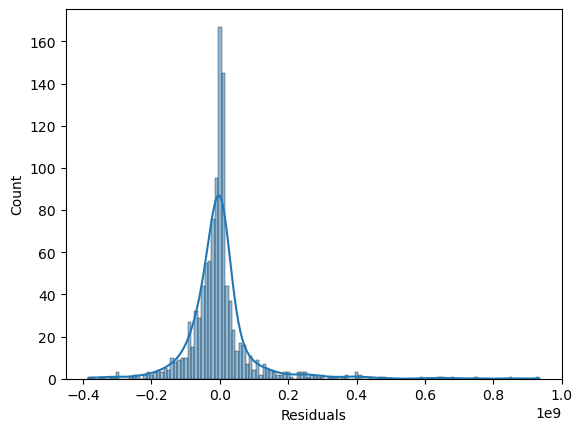

In [30]:
# sm.qqplot(residuals, line='s')

sns.histplot(model_result2.resid, kde=True)
plt.xlabel('Residuals')
plt.show()

### 6) Evaluate Results